In [38]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras import layers
import numpy as np

latent_dim = 100
height = 32
width = 32
channels = 3

#inputに結合する潜在変数の次元数（=画像のラベル数）
class_num = 100

#最適化アルゴリズム
#学習を安定させるために重みをclip＆weight decayを用いる
#識別者の学習ではRMSpropを用いたほうが良いとする事例もある
#またlrを非常に小さくする(0.00005以下)場合もある
#rmsp = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
#識別者用＆敵対者用(DCGAN論文では両方Adam)
adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)

#DC論文ではすべての重みを以下で初期化している
init = keras.initializers.RandomNormal(stddev=0.02)

In [39]:
#生成ネットワーク
generator_input = keras.Input(shape=(latent_dim,))
generator_label = keras.Input(shape=(class_num,), dtype='float32')

model_input = layers.Concatenate()([generator_input, generator_label])

#潜在変数を8x8 128-channels 特徴マップへ変換
x = layers.Dense(128 * 8 * 8,kernel_initializer=init)(model_input)
#この実装では生成ネットワークの活性化関数にLeakyReLUを用いるが
#代わりに以下のBatchNormalization＋LeRUを使う場合もある
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((8, 8, 128))(x)

#8x8 128-channelsを16x16 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)

#16x16 64-channelsを32x32 64-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
x = layers.LeakyReLU(0.2)(x)


#32x32 64-channelsを３２x32 3-channelsの特徴マップへ変換
#最後の出力の活性化関数はtanhを使う
x = layers.Conv2D(channels, 5, activation='tanh', padding='same')(x)
generator = keras.models.Model([generator_input, generator_label], x)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 200)          0           input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 8192)         1646592     concatenate_6[0][0]              
__________

In [40]:
#識別ネットワーク
#LeakyReLU、Dropout、GlobalAveragedPoolingを使うのがポイント
discriminator_input = layers.Input(shape=(height, width, channels))

#inputにlabelを結合
discriminator_label = keras.Input(shape=(height, width, class_num), dtype='float32')
model_input2 = layers.Concatenate()([discriminator_input, discriminator_label])

x = layers.Conv2D(64, 5, strides=2,padding='same',kernel_initializer=init)(model_input2)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model([discriminator_input, discriminator_label], x)
discriminator.summary()


discriminator_optimizer  = adam
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 32, 32, 100)  0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 32, 32, 103)  0           input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 16, 16, 64)   164864      concatenate_7[0][0]              
__________

In [41]:
#敵対的ネットワーク

gan_input = keras.Input(shape=(latent_dim,))
generator_label = keras.Input(shape=(class_num,))
discriminator_label = keras.Input(shape=(height, width, class_num))


#識別ネットワークの学習を止めて
discriminator.trainable = False
#生成ネットワークの学習をする
gan_output = discriminator([generator([gan_input, generator_label]), discriminator_label])
gan = keras.models.Model([gan_input, generator_label, discriminator_label], gan_output)

gan_optimizer = adam 
gan.summary()
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 32, 32, 3)    1848131     input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 32, 32, 100)  0                                            
__________

In [42]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.preprocessing import image
from keras.datasets import cifar100
from tqdm import tqdm
from keras.utils import np_utils

#cifar100のダウンロード
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))

#one-hotへの変換
train_label = np_utils.to_categorical(y_train)
test_label = np_utils.to_categorical(y_test)

#生成者の出力をtanhとしたので
#各ピクセルが[-1,1]の値を取るように正規化
x_train = (x_train.astype('float32')-127.5)/ 127.5
#x_train = x_train.reshape(x_train.shape + (1,))
x_test = (x_test.astype('float32')-127.5)/ 127.5
x_test = x_test.reshape(x_test.shape + (1,))

print(np.shape(test_label))

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(10000, 100)


In [43]:
def set_discriminator_label(label):
    discriminator_label = np.ndarray((len(label), 32, 32, 100))
    for i in range(len(label)):
        discriminator_label[i] = np.tile(label[i], [32, 32, 1])
    return discriminator_label

In [44]:
discrilabel = set_discriminator_label(train_label)
print(discrilabel[0])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [45]:
a = np.ones((10,32,32,3),int)
b = np.full((10,32,32,3),2)
c = np.concatenate([a, b])
np.shape(c)

(20, 32, 32, 3)

In [46]:
#DCGAN論文で使われているバッチ数を使う
batch_size = 128

epochs=30
batchSize=batch_size
batchCount = x_train.shape[0] / batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

sampled_labels = np.arange(0, 100).reshape(-1, 1)

# 学習のループ
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15) 
    #tqdmを使うとプログレスバーが出るがColabだと不安定なので別で代用する
    #for _ in tqdm(range(int(batchCount))): 
    for i in range(int(batchCount)):
        print("\r{0}% [{1}]".format(int(i/(batchCount-1)*100), "*" * int((i+1)/batchCount*50)), end="")
        # 潜在空間からランダムにサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # generatorに入力する画像とlabelを決定する
        imgs = x_train[i*batchSize : (i+1)*batchSize]
        train_labels = train_label[i*batchSize : (i+1)*batchSize]
        
        # データを生成する
        generated_images = generator.predict([random_latent_vectors, train_labels])

        # 観測データと生成データを識別するための入力データをつくる（→discriminatorへ入力する）
        # real_images = x_train[np.random.randint(0, x_train.shape[0], size=batchSize)]
        real_images = x_train[i*batchSize : (i+1)*batchSize]
        combined_images = np.concatenate([generated_images, real_images])

        # discriminatorに入力するラベルを決定する
        discri_labels = discrilabel[i*batchSize : (i+1)*batchSize]
        discri_labels2 = np.concatenate([discri_labels, discri_labels])
        
        # 観測データ(0)と生成データ(1)を識別するラベルをつくる
        labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
        
        # ランダムなノイズを加える
        # ラベルを1ではなく0.7-1.2, 0を0-0.3のようなソフトラベルにすることもある
        #labels += 0.05 * np.random.random(labels.shape)
        labels *= 0.9


        #識別ネットワークの学習
        d_loss = discriminator.train_on_batch([combined_images, discri_labels2], labels)

        #潜在空間からサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # すべてリアルなデータだと騙すためのラベル(y=0)を生成
        misleading_targets = np.zeros((batch_size, 1))

        # 生成ネットワークの学習
        # min -y*log(D(G(z)))
        a_loss = gan.train_on_batch([random_latent_vectors, train_labels, discri_labels], misleading_targets)
        if i==int(batchCount)-1 :
            print("\n") 
            print('discriminator loss: %s' % (d_loss))
            print('adversarial loss  : %s' % (a_loss))
        
      

Epochs: 30
Batch size: 128
Batches per epoch: 390.625
--------------- Epoch 1 ---------------
0% []

INFO:plaidml:Analyzing Ops: 18 of 25 operations complete
INFO:plaidml:Analyzing Ops: 61 of 341 operations complete


99% [*************************************************]

discriminator loss: 0.60035324
adversarial loss  : 1.0760926
--------------- Epoch 2 ---------------
99% [*************************************************]

discriminator loss: 0.5614984
adversarial loss  : 0.88630754
--------------- Epoch 3 ---------------
99% [*************************************************]

discriminator loss: 0.6430824
adversarial loss  : 0.9775153
--------------- Epoch 4 ---------------
99% [*************************************************]

discriminator loss: 0.57931435
adversarial loss  : 0.9699831
--------------- Epoch 5 ---------------
99% [*************************************************]

discriminator loss: 0.6228477
adversarial loss  : 0.9248793
--------------- Epoch 6 ---------------
99% [*************************************************]

discriminator loss: 0.6175586
adversarial loss  : 0.77979255
--------------- Epoch 7 ---------------
99% [*************************************************

INFO:plaidml:Analyzing Ops: 18 of 25 operations complete
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data

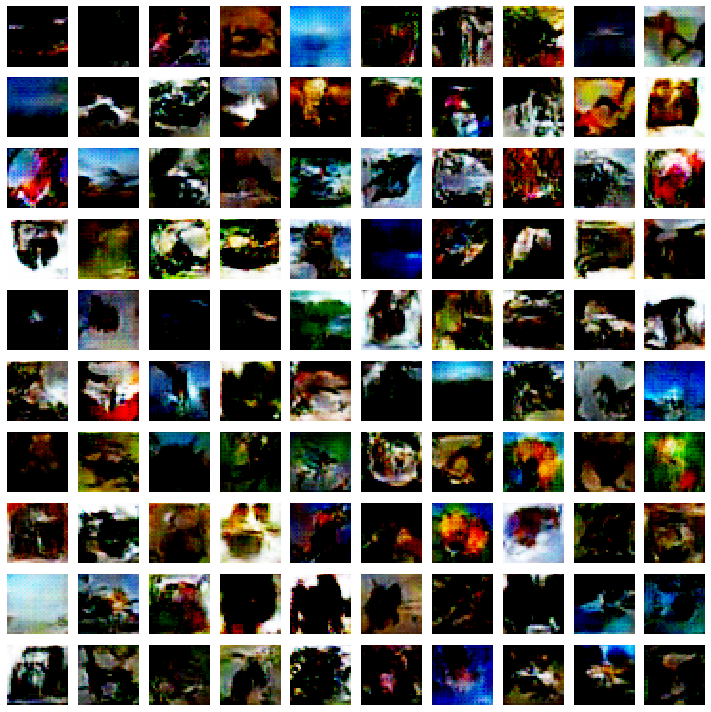

In [47]:
import matplotlib.pyplot as plt

#表示するサンプル数
examples=100
#潜在空間からサンプリング
noise = np.random.normal(0, 1, size=[examples, latent_dim])
#label生成
test = test_label[:100]
#画像を生成
generatedImages = generator.predict([noise, test])

dim=(10, 10)
plt.figure(figsize=(10, 10))
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i].reshape(height, width, channels), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.tight_layout()